## Studying the evolution citrate utilization in the Long Term Evolution Experiment.

We here demonstrate the use of COMETS to study the effect of specific mutations on population dynamics in the context of experimental evolution. To do this, we will use one of the most well known evolution experiments, the *E. coli* Long Term evolution experiment [cite]. 

After ~33,000 generations, a large population expansion was observed in one of the replicates (Ara-3) of the *E. coli* long term evolution experiment (Blount et al 2008). This population expansion is associated with two key mutations that together enable the evolution of strong aerobic citrate use (Cit++ phenotype). The first mutation (occuring roughly 31,000 generations) caused the aerobic expression of the citT transporter, producing a weak citrate growth phenotype (Cit+, Blount et al 2012). A subsequent mutation (occuring roughly 33,000 generations in) caused high-level, constitutive expression of dctA, a proton-driven dicarboxylic acid transporter (Quandt et al 2014). Because these two mutations introduce known reactions into the e.coli metabolic network we can simulate them using COMETS.

This example simulation uses the same models, paramaters and reaction knockouts outlined in (Bajic et al 2018).

First, create the layout and simulate the DM25 medium. 

In [1]:
import cometspy as c
import matplotlib as plt
import cobra.test
import cobra
import pandas as pd
import numpy as np

layout = c.layout()

#Set up media to be DM25
layout.add_typical_trace_metabolites()
layout.set_specific_metabolite('glc__D_e', 0.000139)
layout.set_specific_metabolite('cit_e', 0.0017)

building empty layout model
models will need to be added with layout.add_model()


Now load the model and build the mutants. To show the compatibility with the COBRApy toolbox, we will load the model and perform the mutations using COBRA, and then pass these models as input to build COMETS models. 

Unlike the LTEE ancestral strain REL606 (and *E. coli* in general), which possess the necessary genes for citrate utilization but do not express them in aerobic conditions, iJO1366 is able utilize both citrate and succinate as these reactions are unbounded by default. Thus, the ancestral phenotype can be recreated by knocking out three reactions CITt7pp (citT), SUCCt2_2pp (dctA) and SUCCt2_3pp (dcuA or dcuB). 

In [2]:
# Load the E. coli iJO1366 model 
mod  = cobra.test.create_test_model('ecoli')

# Set exchange reaction lower bounds to -1000 to allow them being controlled by COMETS 
for i in mod.reactions:
    if 'EX_' in i.id:
        i.lower_bound =-1000.0
        
#now create the mutants 
mod.reactions.SUCCt2_3pp.upper_bound=0.0
CitTdctA = mod.copy()
mod.reactions.SUCCt2_2pp.upper_bound =0.0
CitT = mod.copy()
mod.reactions.CITt7pp.upper_bound =0.0
WT = mod.copy()
WT.id= 'Ancestor'
CitT.id = 'Cit+'
CitTdctA.id = 'Cit++'
        
# Generate comets models and set their initial population size
p = c.model(WT)
p.initial_pop = [0, 0, 3.9e-11] # We'll introduce genotypes 100 cells at a time to avoid the risk of them going extinct through drift
p2 = c.model(CitT)
p2.initial_pop = [0, 0, 0] # not present at start
p3 = c.model(CitTdctA)
p3.initial_pop = [0, 0, 0] # not present at start

# Add the models to the simulation 
layout.add_model(p)
layout.add_model(p2)
layout.add_model(p3)

Using license file /home/djordje/gurobi.lic
Academic license - for non-commercial use only
Read LP format model from file /tmp/tmpj1e0_y3y.lp
Reading time = 0.03 seconds
: 1805 rows, 5166 columns, 20366 nonzeros
Read LP format model from file /tmp/tmpikjkpd7n.lp
Reading time = 0.02 seconds
: 1805 rows, 5166 columns, 20366 nonzeros
Read LP format model from file /tmp/tmpabof91tv.lp
Reading time = 0.03 seconds
: 1805 rows, 5166 columns, 20366 nonzeros


Set the parameters for the simulation. We use 1 hr as the COMETS timestep to speed up the simulation. Shortening this to the more commonly used 0.1 hr does not substantially affect the final result, but it does significantly increase the time it takes this simulation to run.

In [3]:
### Setting paramaters for the simulation ###
b_params = c.params()
b_params.all_params['timeStep'] = 1.0 
b_params.all_params['deathRate'] = 0.01
b_params.all_params['batchDilution'] =True
b_params.all_params['dilTime'] =24
b_params.all_params['dilFactor'] =100
b_params.all_params['cellSize']= 3.9e-13 #Size of a single cell
b_params.all_params['minSpaceBiomass'] = 3.8e-13

Perform the simulations. We will divide our simulation in three actual COMETS runs. We will start the simulation at generation 25000 and run for around 6000 generations. At roughly generation 31,000, we introduce the CitT genotype and run for around 2000 Generations. Finally, at roughly Generation 33,000 we introduce the CitTdctA Genotype and run for a final 6000 generations. For each run, we will input the final biomass composition of the previous run. biomass of each store the biomass data in a separate dataframe that we will then join together for analysis. 

These are the expected locations for dependencies:
Dependency 			 expected path
__________ 			 _____________
junit			/home/djordje/Dropbox/COMETS_RUN/lib/junit/junit-4.12.jar
hamcrest			/home/djordje/Dropbox/COMETS_RUN/lib/junit/hamcrest-core-1.3.jar
jogl_all			/home/djordje/Dropbox/COMETS_RUN/lib/jogl/jogamp-all-platforms/jar/jogl-all.jar
gluegen_rt			/home/djordje/Dropbox/COMETS_RUN/lib/jogl/jogamp-all-platforms/jar/gluegen-rt.jar
gluegen			/home/djordje/Dropbox/COMETS_RUN/lib/jogl/jogamp-all-platforms/jar/gluegen.jar
gluegen_rt_natives			/home/djordje/Dropbox/COMETS_RUN/lib/jogl/jogamp-all-platforms/jar/gluegen-rt-natives-linux-amd64.jar
jogl_all_natives			/home/djordje/Dropbox/COMETS_RUN/lib/jogl/jogamp-all-platforms/jar/jogl-all-natives-linux-amd64.jar
jmatio			/home/djordje/Dropbox/COMETS_RUN/lib/JMatIO/lib/jamtio.jar
jmat			/home/djordje/Dropbox/COMETS_RUN/lib/JMatIO/JMatIO-041212/lib/jmatio.jar
concurrent			/home/djordje/Dropbox/COMETS_RUN/lib/colt/lib/concurrent.jar
colt			/ho

In [6]:
cycles_per_day = 24.0/b_params.all_params['timeStep']

# We'll start at Generation 25,000.  and run for around 6000 generations
batch_test = c.comets(layout, b_params)
batch_test.parameters.all_params['maxCycles'] = int(900*cycles_per_day)
batch_test.JAVA_CLASSPATH = '/home/djordje/Dropbox/COMETS_RUN/lib/jmatio.jar:/home/djordje/Dropbox/COMETS_RUN/lib/jdistlib-0.4.5-bin.jar:/home/djordje/Dropbox/COMETS_RUN/lib/commons-math3-3.6.1.jar:/home/djordje/Dropbox/COMETS_RUN/lib/commons-lang3-3.9.jar:/home/djordje/Dropbox/COMETS_RUN/lib/colt.jar:/home/djordje/Dropbox/COMETS_RUN/lib/concurrent.jar:/home/djordje/Dropbox/COMETS_RUN/bin/comets_2.9.3.jar:/opt/gurobi901/linux64/lib/gurobi.jar'
batch_test.run()
phase_1 = pd.DataFrame({'Ancestor' : batch_test.total_biomass.Ancestor/(3.9e-13),
                        'CitT' : batch_test.total_biomass['Cit+']/(3.9e-13),
                        'CitTdctA' : batch_test.total_biomass['Cit++']/(3.9e-13),
                        'Generations' : 6.67*(batch_test.total_biomass.cycle+1)/cycles_per_day + 25000})

# At roughly Generation 31,000 we introduce the CitT genotype and run for around 2000 Generations
batch_test.layout.models[0].initial_pop = [0, 0, float(batch_test.total_biomass.Ancestor.tail(1))]
batch_test.layout.models[1].initial_pop = [0, 0, 3.9e-11]
batch_test.layout.build_initial_pop()
batch_test.parameters.set_param('maxCycles', int(300*cycles_per_day))
batch_test.run()
phase_2 = pd.DataFrame({'Ancestor' : batch_test.total_biomass.Ancestor/(3.9e-13),
                        'CitT' : batch_test.total_biomass['Cit+']/(3.9e-13),
                        'CitTdctA' : batch_test.total_biomass['Cit++']/(3.9e-13),
                        'Generations' : 6.67*(batch_test.total_biomass.cycle)/cycles_per_day + max(phase_1.Generations)})

# At roughly Generation 33,000 we introduce the CitTdctA Genotype and run for a final 6000 generationr 
batch_test.layout.models[0].initial_pop = [0, 0, float(batch_test.total_biomass.Ancestor.tail(1))]
batch_test.layout.models[1].initial_pop = [0, 0, float(batch_test.total_biomass['Cit+'].tail(1))]
batch_test.layout.models[2].initial_pop = [0, 0, 3.9e-11]
batch_test.layout.build_initial_pop()
batch_test.parameters.set_param('maxCycles', int(900*cycles_per_day))
batch_test.run()
phase_3 = pd.DataFrame({'Ancestor' : batch_test.total_biomass.Ancestor/(3.9e-13),
                        'CitT' : batch_test.total_biomass['Cit+']/(3.9e-13),
                        'CitTdctA' : batch_test.total_biomass['Cit++']/(3.9e-13),
                        'Generations' : 6.67*(batch_test.total_biomass.cycle)/cycles_per_day + max(phase_2.Generations) })


Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!


Group all the results from the three runs together and plot the stationary phase population size through time. 

In [8]:
#Remove the final timepoint from each phase
phase_1.drop(phase_1.tail(1).index, inplace=True)
phase_2.drop(phase_2.tail(1).index, inplace=True)
phase_3.drop(phase_3.tail(1).index, inplace=True)

final_df = pd.concat([phase_1,phase_2,phase_3])
final_df.reindex()
final_df = final_df[np.round((final_df.Generations - 25000) % 6.67,3) == 6.67]

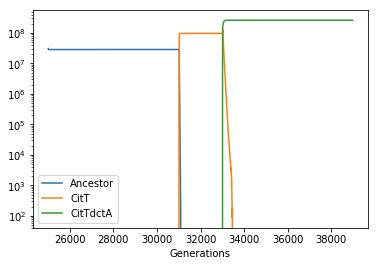

In [16]:
fig = final_df.plot(x='Generations')
fig.set_yscale("log")